In [1]:
#import reqiired library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import logging
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', None)

In [2]:
logging.basicConfig(filename='Project_6 task2 file.log',
                    level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filemode='a')
logger = logging.getLogger("data_processing")
logger.debug("This is a debug message")
logger.info("This is an info message")
logger.warning("This is a warning message")
logger.error("This is an error message")
logger.critical("This is a critical message")
print("Logging setup complete. Check 'jupyter_log.log' for logs.")

Logging setup complete. Check 'jupyter_log.log' for logs.


In [4]:
# Loading the data
train_store = pd.read_excel(r'E:\Project_6_Sales Forecasting Across Multiple Retail Store\train_store.xlsx')

In [5]:
test_store = pd.read_excel(r'E:\Project_6_Sales Forecasting Across Multiple Retail Store\test_store.xlsx')

In [6]:
test_store1 = pd.read_excel(r'E:\Project_6_Sales Forecasting Across Multiple Retail Store\test_store1.xlsx')

In [7]:
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,4,2015-07-31,5263,555,1,1,0,1,c,a,1270,9,2008,0,22,2012,"Jan,Apr,Jul,Oct",2015,7,31,31
1,2,4,2015-07-31,6064,625,1,1,0,1,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,4,2015-07-31,8314,821,1,1,0,1,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,4,2015-07-31,13995,1485,1,1,0,1,c,c,620,9,2009,0,22,2012,"Jan,Apr,Jul,Oct",2015,7,31,31
4,5,4,2015-07-31,4822,559,1,1,0,1,a,a,16135,4,2015,0,22,2012,"Jan,Apr,Jul,Oct",2015,7,31,31


In [8]:
# Function to preprocess data
def preprocess_data(df):

    categorical_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
    for col in categorical_cols:
        df[col] = df[col].astype(str)

    df['Open'].fillna(1, inplace=True)

    df['Date'] = pd.to_datetime(df['Date'])

    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['Weekday'] = df['Date'].dt.weekday
    df['IsWeekend'] = df['Weekday'] >= 5
    df['IsBeginningOfMonth'] = df['Day'] <= 10
    df['IsMidMonth'] = (df['Day'] > 10) & (df['Day'] <= 20)
    df['IsEndOfMonth'] = df['Day'] > 20
    df['Quarter'] = df['Date'].dt.quarter
    df['IsHolidaySeason'] = df['Month'].isin([11, 12])

    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())
    df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(df['CompetitionOpenSinceYear'].mode()[0])
    df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(df['CompetitionOpenSinceMonth'].mode()[0])
    df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0)
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0)
    df['PromoInterval'].replace('nan', np.nan, inplace=True)
    df['PromoInterval'] = df['PromoInterval'].fillna('')

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    df['PromoIntervalMonths'] = df['PromoInterval'].apply(lambda x: [month_map[m] for m in x.split(',')] if x else [])
    df.drop('PromoInterval',axis = 1, inplace = True)

    df['PromoRunningDays'] = df.apply(lambda row: (row['Date'] - pd.Timestamp(f"{row['Year']}-{min(row['PromoIntervalMonths'])}-01")).days if row['Promo'] == 1 and row['PromoIntervalMonths'] else 0, axis=1)

    df['CompetitionDurationMonths'] = ((df['Year'] - df['CompetitionOpenSinceYear']) * 12) + (df['Month'] - df['CompetitionOpenSinceMonth'])
    df['CompetitionDurationMonths'] = df['CompetitionDurationMonths'].apply(lambda x: x if x > 0 else 0)

    return df

In [9]:
# Preprocess the data
train_store = preprocess_data(train_store)
test_store = preprocess_data(test_store)

In [10]:
# Check null values
train_store.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
Weekday                      0
IsWeekend                    0
IsBeginningOfMonth           0
IsMidMonth                   0
IsEndOfMonth                 0
Quarter                      0
IsHolidaySeason              0
PromoIntervalMonths          0
PromoRunningDays             0
CompetitionDurationMonths    0
dtype: int64

In [11]:
test_store.isnull().sum()

Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
Weekday                      0
IsWeekend                    0
IsBeginningOfMonth           0
IsMidMonth                   0
IsEndOfMonth                 0
Quarter                      0
IsHolidaySeason              0
PromoIntervalMonths          0
PromoRunningDays             0
CompetitionDurationMonths    0
dtype: int64

In [12]:
# Define features and target
features_train = ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',
             'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2',
             'Promo2SinceWeek','Promo2SinceYear', 'Year','Month', 'Day',
             'WeekOfYear', 'Weekday', 'IsWeekend','IsBeginningOfMonth', 'IsMidMonth', 'IsEndOfMonth', 'Quarter',
             'IsHolidaySeason', 'PromoRunningDays','CompetitionDurationMonths']
features_test = ['Store', 'DayOfWeek', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',
             'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2',
             'Promo2SinceWeek','Promo2SinceYear', 'Year','Month', 'Day',
             'WeekOfYear', 'Weekday', 'IsWeekend','IsBeginningOfMonth', 'IsMidMonth', 'IsEndOfMonth', 'Quarter',
             'IsHolidaySeason', 'PromoRunningDays','CompetitionDurationMonths']
target = 'Sales'

In [13]:
train_store['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [14]:
train_store['StoreType'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [15]:
train_store['Assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

In [16]:
# Preprocess the categorical and numerical features
categorical_features = ['StateHoliday', 'StoreType', 'Assortment', 'IsWeekend',
                        'IsBeginningOfMonth','IsMidMonth', 'IsEndOfMonth', 'IsHolidaySeason']
numerical_features = ['Store', 'DayOfWeek', 'Promo','Customers', 'Open', 'SchoolHoliday',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
            'Promo2SinceWeek', 'Promo2SinceYear','Year', 'Month', 'Day',
            'WeekOfYear', 'Weekday', 'Quarter','IsHolidaySeason', 'PromoRunningDays', 'CompetitionDurationMonths']

In [17]:
# Create pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

In [18]:
# Copy to actual data
train_store2 = train_store.copy()

In [19]:
# Ordinal encoding of categorical columns
train_store2[categorical_features] = categorical_transformer.fit_transform(train_store2[categorical_features])
test_store[categorical_features] = categorical_transformer.fit_transform(test_store[categorical_features])

In [20]:
# check information of features
train_store2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 31 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  float64       
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  float64       
 10  Assortment                 1017209 non-null  float64       
 11  CompetitionDistance        1017209 no

In [21]:
train_store2 = train_store2.set_index(['Date'])
test_store = test_store.set_index(['Date'])

In [22]:
X = train_store2[features_train]
y = train_store[target]

In [23]:
# Split the data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Make pipeline for imputing and scaling of dataset as all the colums are numerical now
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

In [25]:
# scaling of train and test dataset
X_train = numerical_transformer.fit_transform(X_train)
X_test = numerical_transformer.transform(X_test)

In [26]:
# Apply PCA at dataset
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [27]:
X_train_pca

array([[ 1.43847546,  0.50419253, -0.08618096],
       [ 1.27487563, -0.01676181,  1.29094444],
       [ 0.00917644, -0.60932463,  0.58397283],
       ...,
       [ 0.63665037, -0.89571675, -0.17850638],
       [-0.71045185, -0.54858086,  1.30169046],
       [-0.88991954, -0.12244488, -0.56104093]])

In [28]:
X_test_pca

array([[ 1.45236819,  0.49452772, -0.30272293],
       [-0.77363842,  0.80300533, -0.49430019],
       [ 0.69003672, -0.06752032,  0.4207833 ],
       ...,
       [ 0.9401019 ,  0.66440293, -0.29920782],
       [ 1.31774992, -1.04354684, -0.49174114],
       [ 0.49604615, -0.58199475,  1.33689229]])

In [29]:
# make model after applying pca at data
RFR = RandomForestRegressor()

In [30]:
RFR.fit(X_train_pca,y_train)

RandomForestRegressor()

In [31]:
# Predict the model with test dataset
y_pred_pca = RFR.predict(X_test_pca)

In [32]:
# Build model with the pipelines
simple_imputer = SimpleImputer(strategy='median')
s_scaler = StandardScaler()
rfr_model = RandomForestRegressor(n_estimators=150,random_state=42)

rfr_pipeline = Pipeline([
    ('s_imputer',simple_imputer),
    ('s_scaler',s_scaler),
    ('model',rfr_model)
])

In [33]:
# Split the data into train and validation sets
x_train, x_test, Y_train, Y_test = train_test_split(X[['Customers','Open','Promo','StateHoliday','SchoolHoliday',
                    'CompetitionDistance','Day','Weekday','Month','Year']], y, test_size=0.2, random_state=42)

In [34]:
# Fit the data in pipeline and Train the model
rfr_pipeline.fit(x_train,Y_train)

Pipeline(steps=[('s_imputer', SimpleImputer(strategy='median')),
                ('s_scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(n_estimators=150, random_state=42))])

In [35]:
# Score of model
rfr_pipeline.score(x_test,Y_test)

0.9577452214949864

In [36]:
# Make predictions
logger.info("Making predictions...")
y_pred = rfr_pipeline.predict(x_test)

In [37]:
y_pred

array([    0.        ,  6407.03333333,  7750.02      , ...,
        4416.23444444,     0.        , 13985.67333333])

In [38]:
# Evaluate the model
mae = mean_absolute_error(Y_test, y_pred)
logger.info(f"Mean Absolute Error: {mae}")

In [39]:
# make dataframe for future prediction
x_future = x_test.copy()
for i  in range(1,7):
    x_future = pd.concat([x_future, x_test.tail(i)],ignore_index=True)

In [40]:
rfr_pred = rfr_pipeline.predict(x_future)

In [41]:
# Get the last date in the index
last_date = x_test.index[-1]

future_dates = []

current_date = pd.to_datetime(last_date)

for i in range(0, len(rfr_pred), 10000):
    batch_dates = pd.date_range(start= current_date + pd.Timedelta(days=1), periods= min(10000,len(rfr_pred)-i),freq='D')
    future_dates.extend(batch_dates)

rfr_pred_series = pd.Series(rfr_pred, index = future_dates)

print('Predicted sales for next six weeks is: ')
print(rfr_pred_series)

Predicted sales for next six weeks is: 
2014-12-07        0.000000
2014-12-08     6407.033333
2014-12-09     7750.020000
2014-12-10     3557.880000
2014-12-11    10754.897778
                  ...     
2024-05-26     7891.046667
2024-05-27    10788.906667
2024-05-28     4416.234444
2024-05-29        0.000000
2024-05-30    13985.673333
Length: 203463, dtype: float64


In [42]:
# Check R2 score of model
from sklearn.metrics import r2_score
rfr_score = r2_score(Y_test,rfr_pred[0:203442])
rfr_score

0.9577452214949864

In [43]:
# Define Huber loss function
def huber_loss(Y_test, y_pred, delta=1.0):
    error = Y_test - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * np.square(error)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss).mean()

In [44]:
# Make Huber loss scorer
huber_scorer = make_scorer(huber_loss, greater_is_better=False)

In [45]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)

In [46]:
# Check loss using defined model
import time

start_time = time.time()
try:
    scores = cross_val_score(model, x_train, Y_train, scoring=huber_scorer, cv=5)
    print("Huber Loss: ", -scores.mean())
except MemoryError as e:
    print("MemoryError: ", e)
except Exception as e:
    print("Exception: ", e)

end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")

Huber Loss:  710.7573374804651
Execution Time: 973.3734035491943 seconds


In [47]:
# Also calculate mean absolute error and mean squared error for both the models

mse1 = mean_squared_error(Y_test,y_pred)
rmse1 = np.sqrt(mse1) 
mae1 = mean_absolute_error(Y_test,y_pred)

print('Mean Squared Error is: ', mse1)
print('Root Mean Squared Error is: ',rmse1)
print('Mean Absolute Error is: ', mae1)

Mean Squared Error is:  545598.652666078
Root Mean Squared Error is:  738.6465004764308
Mean Absolute Error is:  454.81389243884155


In [48]:
# Losses of complete dataset
mse2 = mean_squared_error(y_test,y_pred_pca)
rmse2 = np.sqrt(mse2)  
mae2 = mean_absolute_error(y_test,y_pred_pca)

print('Mean Squared Error is: ', mse2)
print('Root Mean Squared Error is: ',rmse2)
print('Mean Absolute Error is: ', mae2)

Mean Squared Error is:  2068627.1653629264
Root Mean Squared Error is:  1438.2722848483616
Mean Absolute Error is:  1001.1171320081397


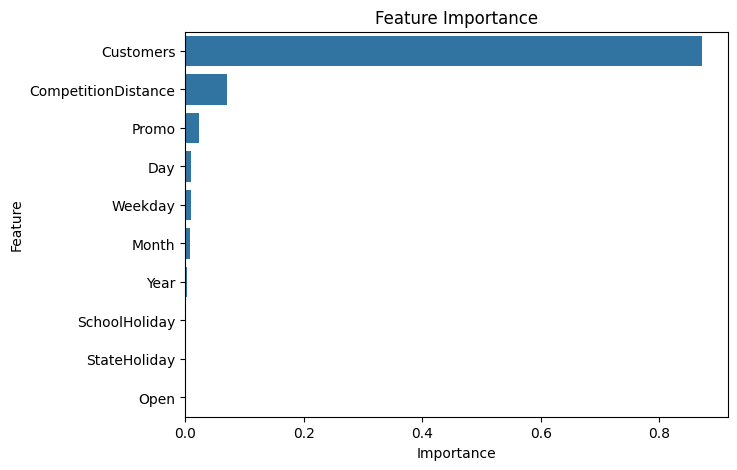

In [49]:
# Function to analyze feature importance
def analyze_feature_importance(rfr, feature_names):
    logger.info("Analyzing feature importance...")
    imputer = rfr.named_steps['s_imputer']
    scaler = rfr.named_steps['s_scaler']
    regressor = rfr.named_steps['model']

    transformed_feature_names = imputer.get_feature_names_out()

    importances = regressor.feature_importances_

    importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(7, 5))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.show()

    logger.info("Feature importance analysis completed.")
    return importance_df

feature_importance_df = analyze_feature_importance(rfr_pipeline, features_train)

In [50]:
# Top 10 features
feature_importance_df

,Feature,Importance
0,Customers,0.871617
5,CompetitionDistance,0.070869
2,Promo,0.023111
6,Day,0.010500
7,Weekday,0.009877
8,Month,0.008830
9,Year,0.003530
4,SchoolHoliday,0.001463
3,StateHoliday,0.000204
1,Open,0.000000


In [51]:
# Calculate the confidence intervals
def prediction_intervals(rfr_pipeline, features, alpha=0.05):
    rfr_predict = rfr_pipeline.predict(features)
    std_error = np.std([tree.predict(features) for tree in rfr_pipeline.named_steps['model'].estimators_], axis=0)
    z_score = norm.ppf(1 - alpha / 2)
    lower_bound = rfr_predict - z_score * std_error
    upper_bound = rfr_predict + z_score * std_error
    return lower_bound, upper_bound

lower_bound, upper_bound = prediction_intervals(rfr_pipeline, x_test)

In [52]:
# Print the results
for i in range(5): 
    logger.info(f"Prediction: {y_pred[i]}, CI: ({lower_bound[i]}, {upper_bound[i]})")

In [53]:
lower_bound

array([ -875.04003232,  6124.78176466,  7286.57519788, ...,
        3952.78964233,  -875.04003232, 13522.22853122])

In [54]:
upper_bound

array([  875.04003232,  6689.28490201,  8213.46480212, ...,
        4879.67924656,   875.04003232, 14449.11813545])

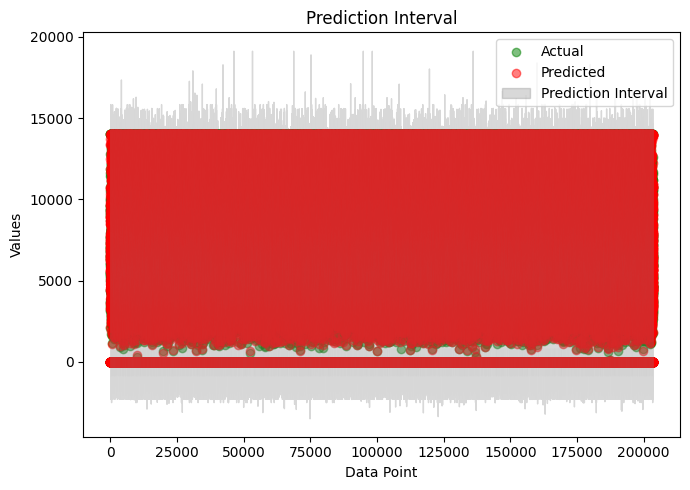

In [55]:
#plotting
plt.figure(figsize=[7,5])
plt.scatter(range(len(Y_test)),Y_test,color = 'green', label = 'Actual', alpha=0.5)
plt.scatter(range(len(rfr_pred)),rfr_pred,color = 'red', label = 'Predicted', alpha=0.5)
plt.fill_between(range(len(lower_bound)),lower_bound,upper_bound, color = 'grey',alpha = 0.3, label = 'Prediction Interval')
plt.xlabel('Data Point')
plt.ylabel('Values')
plt.title('Prediction Interval')
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
# Saving datasets for use
train_store2.to_csv('df_train_for_deeplearning.csv')
test_store.to_csv('df_test_for_deeplearning.csv')